# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `01`
* Students: `Timothée Bornet dit Vorgeat, Yassine Zouaghi, Pol Boudou, Icíar Lloréns Jover`
* Dataset: `IMDb Films and Crew`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [29]:
DATA_PATH = "DataMS1/"
adjacency =  np.load(DATA_PATH + 'adjacency.npy')
n_nodes =  len(adjacency)

L = int(np.count_nonzero(adjacency)/2)

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [19]:
degree_weighted_imdb = adjacency.sum(1)
D = np.diag(degree_weighted_imdb)

In [24]:
D_norm = np.diag(np.sqrt(1./degree_weighted_imdb))

D_norm[D_norm == np.inf] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [28]:
# We use the formulae presented in the course
laplacian_combinatorial = sparse.csr_matrix(D - adjacency)
laplacian_normalized =  sparse.csr_matrix(D_norm*laplacian_combinatorial*D_norm)

# To verify results. Delete later on
laplacian_comb = sparse.csr_matrix(sparse.csgraph.laplacian(adjacency, normed=False))
laplacian_norm = sparse.csr_matrix(sparse.csgraph.laplacian(adjacency, normed=True))

diff = laplacian_normalized - laplacian_norm
diff2 = laplacian_combinatorial - laplacian_comb

diff.max()
# diff2.max()

0.8017837257372731

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

# Tim, Pol: Expliquez pourquoi vous avez pris celui-là

In [30]:
laplacian = laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [31]:
# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(laplacian.toarray())
eigenvaluesNorm, eigenvectorsNorm = np.linalg.eig(laplacian_norm.toarray())

# We order eigenvalues while keeping the index for eigenvectors
idx = eigenvalues.argsort()[::1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

idx_ = eigenvaluesNorm.argsort()[::1]
eigenvaluesNorm = eigenvalues[idx_]
eigenvectorsNorm = eigenvectors[:, idx_]

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Your answer here.**

We choose to use the numpy eigen decomposition `np.linalg.eig` in order to get all N eigenvalues. Eigensolver `scipy.sparse.linalg.eigs` is not ideal for us as it gives just a maximum of $k = N-1$ eigenvalues.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

#VERIFYYYY

The matrix $S$ is the incidence matrix, which has a row for each vertex $v$ and column for each edge $e$, and $(v,e)=1$ if vertex $v$ is incident upon edge $e$. We can write $L = S S^\top$.

If $x$ is a vector $N \times 1$, $S^\top x$ computes the gradient of $x$ through the edges $e$ of the graph.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

The eigendecomposition of laplacian L gives us eigen value $\lambda_k$ and eigen vectors $u_k$.

$\lambda_k = u_k^\top L u_k = (u_k^\top S)(S^\top u_k) = (S^\top u_k)^\top(S^\top u_k) =  \| S^\top u_k \|_2^2$

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

$\| S^\top x \|_2^2$ is the squared Euclidean norm of the gradient of x. Thus, it quantifies how smooth the signal $x$ is.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your answer here.**

First eigenvector

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

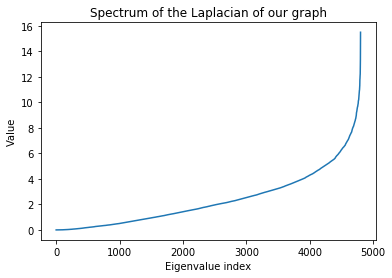

In [34]:
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue index')
plt.ylabel('Value')
plt.title('Spectrum of the Laplacian of our graph')
plt.show()

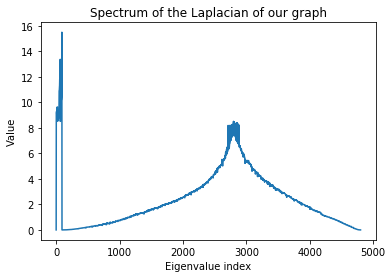

In [35]:
# delete later on
plt.plot(eigenvaluesNorm)
plt.xlabel('Eigenvalue index')
plt.ylabel('Value')
plt.title('Spectrum of the Laplacian of our graph')
plt.show()

**Your answer here.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [36]:
# Multiplicity of eigenvalue 0 gives connectedness of graph
zero_multiplicity = np.count_nonzero(eigenvalues==0)

print("Multiplicity of eigenvalue 0 gives connectedness of graph: our graph has {mult} components".format(mult=zero_multiplicity))

Multiplicity of eigenvalue 0 gives connectedness of graph: our graph has 90 components


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

Graph Embeddings are used to reduce the dimension of the dataset in order to help with computation time and help to visualize the data.

https://datascience.stackexchange.com/questions/24081/what-are-graph-embedding

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

**OBSERVATIONS**

**We got the biggest connected component of our graph from the first Milestone and saved it locally. We will use it for the following questions.**

**We redo the eigendecomposition with the laplacian from this new graph.**

In [13]:
biggest_weights =  np.load(DATA_PATH + 'biggest.npy')
biggest_adjacency = biggest_weights/biggest_weights.max()
n_nodes_b =  len(biggest_weights)

FileNotFoundError: [Errno 2] No such file or directory: 'DataMS1/biggest.npy'

In [62]:
biggest_degree_weighted_imdb = biggest_weights.sum(1)

D = np.diag(biggest_degree_weighted_imdb)

D_norm = np.diag(np.sqrt(1./biggest_degree_weighted_imdb))

D_norm[D_norm == np.inf] = 0

laplacian_combinatorial = sparse.csr_matrix(D - biggest_weights)
laplacian_normalized =  sparse.csr_matrix(D_norm*laplacian_combinatorial*D_norm)

In [63]:
biggest_laplacian = laplacian_combinatorial

The eigenvector corresponding to the smallest eigenvalue $u_o$ is constant since the graph is connected. So the 2 eigenvectors that interest us are the second and third.

In [67]:
b_eigenvalues, b_eigenvectors = scipy.sparse.linalg.eigs(biggest_laplacian, k=3, which = 'SR')

assert b_eigenvectors.shape == (n_nodes_b, 3)

In [78]:
b_eigenvectors = np.real(b_eigenvectors)

Plot the nodes embedded in 2D. Comment on what you see.

In [81]:
projection_x = np.matmul(biggest_adjacency,b_eigenvectors[:,1])
projection_y = np.matmul(biggest_adjacency,b_eigenvectors[:,2])

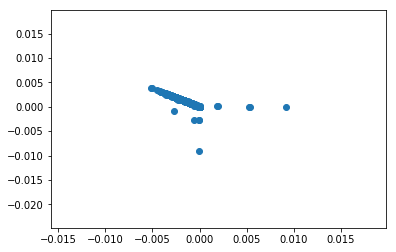

In [85]:
plt.scatter(projection_x,projection_y)

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
# Your code here.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
[1 2 3 0 1 3 4]
[1 2 3 1 0 4 4]
3/7 error
4/7 true

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**